# FIAP 10DTSR - Trabalho Final - Cognitive Environments

- Matheus Vitor da Silva Souza | RM: 358585
- Maurício Mourão Jorge | RM: 359495
- Lucian Cláudio da Silva | RM: 359082

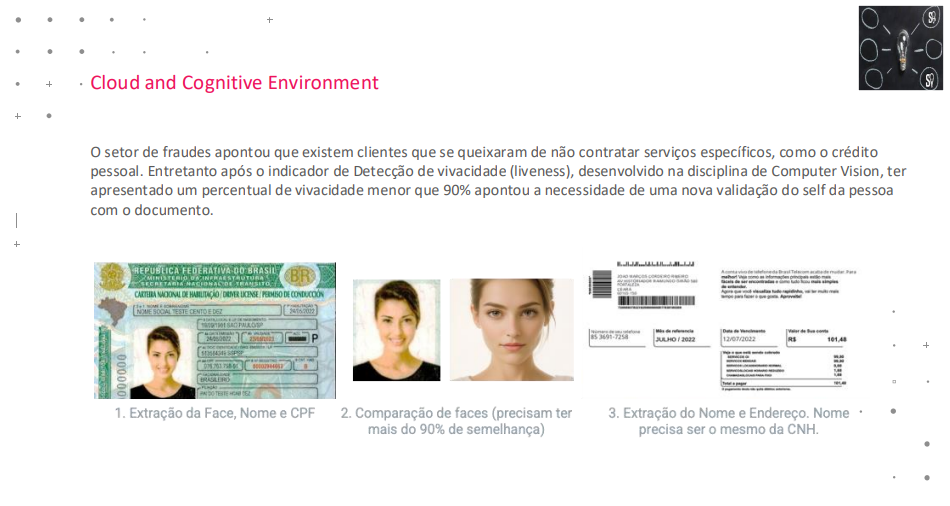

## Configurações iniciais

### Parâmetros

In [ ]:
# Mínimo de confiança na leitura das informações da CNH
cnh_confianca_minima = 70.00   # limiar aceitável (%)

# Mínimo de similaridade entre a CNH e comprovante de residência
comprovante_similaridade_minima = 70.00   # limiar aceitável (%)

# Mínimo de similaridade entre a CNH e a Selfie
selfie_similaridade_minima = 95.00   # limiar aceitável (%)

### Instalando e importando as bibliotecas

In [ ]:
!pip install boto3 --quiet
!pip install pillow --quiet
!pip install openai requests pillow --quiet
!pip install pdf2image --quiet
!apt-get install -y poppler-utils --quiet

In [ ]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import openai
import base64
import io
from google.colab import files, userdata
import matplotlib.pyplot as plt
import os
import unicodedata
import json
import re
from pdf2image import convert_from_path
from pathlib import Path
from IPython.display import Markdown, display

In [ ]:
# Utilizando o Secrets do Google Colab para armazenar as chaves das APIs

# Chaves de acesso AWS
ACCESS_ID = userdata.get('aws_access_id')
ACCESS_KEY = userdata.get('aws_access_key')
region = "us-east-1"

# API key OpenAI
openai_api_key = userdata.get('openai_api_key')
openai_model="gpt-4o"

## Upload dos documentos

### CNH

In [ ]:
# Upload da CNH
print("Fazer upload da CNH (Imagem ou PDF):")
uploaded = files.upload()
cnh_foto = next(iter(uploaded))

### Comprovante de residência

In [ ]:
# Upload do comprovante de residencia
print("Fazer upload do comprovante de residencia (Imagem ou PDF):")
uploaded = files.upload()
comprovante = next(iter(uploaded))

### Selfie

In [ ]:
# Upload da selfie
print("Fazer upload da selfie:")
uploaded = files.upload()
selfie = next(iter(uploaded))

## Extração de NOME e CPF da CNH

### Extrair o texto da imagem da CNH utilizando o serviço AWS Textract

In [ ]:
def processar_arquivo(caminho: str) -> str:

# Carrega a imagem ou converte o PDF da CNH
    ext = os.path.splitext(caminho)[1].lower()

    if ext == ".pdf":
        # Converte apenas a primeira página em alta resolução
        pil_img = convert_from_path(
            caminho, first_page=1, last_page=1, dpi=300, fmt="png"
        )[0]
    else:
        pil_img = Image.open(caminho)

    # Exibe a imagem no notebook
    plt.imshow(pil_img)
    plt.axis("off")
    plt.show()

    # Empacota a imagem em bytes PNG para o Textract
    buf = io.BytesIO()
    pil_img.save(buf, format="PNG")
    imagem_bytes = buf.getvalue()

# Envia para a AWS Textract
    s = boto3.Session(
        aws_access_key_id=ACCESS_ID,
        aws_secret_access_key=ACCESS_KEY,
        region_name=region,
    )
    textract = s.client("textract")
    resp = textract.analyze_document(
        Document={"Bytes": imagem_bytes},
        FeatureTypes=["FORMS"],
    )

# Filtra texto com confiança
    cnh_palavras = [
        b["Text"]
        for b in resp["Blocks"]
        if b["BlockType"] == "WORD" and b["Confidence"] > cnh_confianca_minima
    ]

    return " ".join(cnh_palavras)

In [ ]:
cnh_texto = processar_arquivo(cnh_foto)
print("\nTexto extraído pelo AWS Textract")
print(cnh_texto)

### Delimitar o NOME e CPF do texto obtido, usando REGEX

In [ ]:
def cnh_extrair_nome_cpf(cnh_texto_extraido):
    cnh_texto_extraido = " ".join(cnh_texto_extraido.split())

# Define o padrão para extração do NOME
    cnh_padrao_nome = (
        r"\bNOME\s+"
        r"([A-ZÀ-Ü\s]+?)\s+"
        r"(?:CPF|DOC|DATA|FILIAÇÃO|\d{3}\.\d{3}\.\d{3}-\d{2})"
    )

# Define o padrão para extração do CPF
    cnh_padrao_cpf = r"\bCPF\b[^0-9]{0,30}(\d{3}\.\d{3}\.\d{3}-\d{2})"

    cnh_nome_encontrado = re.search(cnh_padrao_nome, cnh_texto_extraido, flags=re.IGNORECASE)
    nome = cnh_nome_encontrado.group(1).upper().strip() if cnh_nome_encontrado else "Nome não encontrado"

    cnh_cpf_encontrado = re.search(cnh_padrao_cpf, cnh_texto_extraido, flags=re.IGNORECASE)
    cpf = cnh_cpf_encontrado.group(1) if cnh_cpf_encontrado else "CPF não encontrado"

    return {"nome": nome, "cpf": cpf}

cnh_dados = cnh_extrair_nome_cpf(cnh_texto)
print(cnh_dados)

cnh_nome = cnh_dados["nome"]
cnh_cpf = cnh_dados["cpf"]

## Extração do NOME e ENDEREÇO no comprovante de residência

In [ ]:
def comparar_nomes(nome1, nome2):
    if not nome1 or not nome2:
        return False

    def normalizar_nome(nome):
        nome = nome.upper()
        nome = unicodedata.normalize('NFKD', nome).encode('ASCII', 'ignore').decode('ASCII')
        nome = re.sub(r'[^\w\s]', '', nome)
        return ' '.join(nome.split())

    nome1_norm = normalizar_nome(nome1)
    nome2_norm = normalizar_nome(nome2)

    if nome1_norm == nome2_norm:
        return True
    if nome1_norm in nome2_norm or nome2_norm in nome1_norm:
        return True

    palavras1 = set(nome1_norm.split())
    palavras2 = set(nome2_norm.split())
    palavras_comuns = palavras1.intersection(palavras2)
    min_palavras = min(len(palavras1), len(palavras2))

    if min_palavras > 0 and len(palavras_comuns) / min_palavras >= 0.7:
        return True

    return False

### Usando a API da OpenAI para extrair o NOME e o ENDEREÇO do comprovante de residência

In [ ]:
# Processa o arquivo (PDF ou imagem) e extrai informações com a API da OpenAI
def extrair_texto_com_openai(caminho_arquivo: str, api_key: str):
    openai.api_key = api_key
    extensao = os.path.splitext(caminho_arquivo)[1].lower()

    # Prepara a imagem (converte PDF ou abre imagem)
    if extensao == ".pdf":
        # Converte a primeira página do PDF para uma imagem PNG
        imagem = convert_from_path(caminho_arquivo, first_page=1, last_page=1, fmt="png")[0]
        formato = "png"
    else:
        imagem = Image.open(caminho_arquivo)
        # Garante um formato compatível para a API
        formato = imagem.format.lower() if imagem.format else 'png'
        if formato not in ["jpg", "jpeg", "png"]:
            formato = "png"

    # Converte a imagem para base64 para envio na requisição
    buffer = io.BytesIO()
    # Converte para RGB se for RGBA (com canal de transparência) para evitar erros ao salvar
    if imagem.mode == 'RGBA':
        imagem = imagem.convert('RGB')
    imagem.save(buffer, format=formato.upper())
    imagem_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    try:
        # Realiza uma chamada única à API, solicitando a resposta diretamente em JSON
        resposta = openai.chat.completions.create(
            model="gpt-4o",
            response_format={"type": "json_object"},  # Força a saída da API para o formato JSON
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": (
                                "Analise a imagem deste comprovante de residência. "
                                "Extraia o nome completo do titular e o endereço completo. "
                                "Retorne os dados em um formato JSON com as chaves 'comprovante_nome' e 'comprovante_endereco'. "
                                "Se alguma dessas informações não for encontrada, retorne uma string vazia para a chave correspondente."
                            )
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/{formato};base64,{imagem_base64}"}
                        }
                    ]
                }
            ],
            max_tokens=1000
        )

        # O conteúdo da resposta já é uma string JSON, eliminando a necessidade de Regex
        resultado_str = resposta.choices[0].message.content
        dados = json.loads(resultado_str)

        # Extrai os dados do JSON de forma segura com .get()
        nome = dados.get("comprovante_nome", "")
        endereco = dados.get("comprovante_endereco", "")

        return nome, endereco

    except Exception as erro:
        print(f"Erro ao processar o arquivo com a OpenAI: {erro}")
        return None, None

def comparar_nomes(nome1, nome2):
    """
    Compara dois nomes com normalização. Retorna True para correspondências
    exatas ou para casos com alta similaridade de palavras.
    """
    # A variável global `comprovante_similaridade_minima` deve estar definida.
    if not nome1 or not nome2:
        return False

    def limpar(nome):
        nome = unicodedata.normalize("NFKD", nome.upper()).encode("ASCII", "ignore").decode("ASCII")
        return re.sub(r"[^\w\s]", "", nome).strip()

    n1 = limpar(nome1)
    n2 = limpar(nome2)

    # Verificação 1: Apenas correspondência exata.
    # A verificação "in" foi removida para evitar falsos positivos.
    if n1 == n2:
        return True

    # Verificação 2: Proporção de palavras em comum.
    # Esta parte agora será usada para todos os casos não idênticos.
    palavras1 = set(n1.split())
    palavras2 = set(n2.split())

    if not palavras1 or not palavras2:
        return False

    comuns = palavras1 & palavras2
    minimo_palavras = min(len(palavras1), len(palavras2))

    if minimo_palavras > 0:
        proporcao = len(comuns) / minimo_palavras
        return proporcao >= (comprovante_similaridade_minima / 100.0)

    return False

### Comparar o comprovante de residencia com a CNH

In [ ]:
# Carrega o arquivo, extrai dados e compara com o nome da CNH
def validar_conta(cnh_nome):

    comprovante_nome, endereco = extrair_texto_com_openai(comprovante, openai_api_key)

    print("\nDados da CNH")
    print(f"Nome completo: {cnh_nome}")

    print("\nDados do comprovante de residencia")
    print(f"Nome completo: {comprovante_nome or 'Não identificado'}")
    print(f"Endereço: {endereco or 'Não identificado'}")

    if comprovante_nome:
        nomes_correspondem = comparar_nomes(cnh_nome, comprovante_nome)
        print(f"Nomes correspondem: {'SIM' if nomes_correspondem else 'NÃO'}")
        return comprovante_nome, endereco, nomes_correspondem

    print("Não foi possível comparar os nomes.")
    return None, endereco, False

# Execução
try:
    nome_conta, endereco_conta, correspondencia = validar_conta(cnh_nome)
except NameError:
    cnh_nome = input("Digite o nome extraído da CNH: ")
    nome_conta, endereco_conta, correspondencia = validar_conta(cnh_nome)

## Comparar foto da CNH com a Selfie

### Usa o AWS Rekognition para comparar a foto da CNH e a Selfie

In [ ]:
def load_image_bytes(path: str) -> bytes:
    """
    Retorna bytes JPEG prontos para o Rekognition.
    - Se for PDF → converte a 1ª página para JPEG.
    - Se for imagem → garante formato JPEG (RGB).
    """
    ext = Path(path).suffix.lower()
    if ext == ".pdf":
        # Converte a primeira página do PDF
        page = convert_from_path(path, dpi=300, first_page=1, last_page=1)[0]
        buf = io.BytesIO()
        page.save(buf, format="JPEG", quality=90)
        return buf.getvalue()
    else:
        with Image.open(path) as im:
            if im.format in ("JPEG", "PNG"):
                # Já é JPEG/PNG
                with open(path, "rb") as f:
                    return f.read()
            # Outros formatos → converte
            buf = io.BytesIO()
            im.convert("RGB").save(buf, format="JPEG", quality=90)
            return buf.getvalue()

# Carrega arquivos no formato correto
bytes_cnh   = load_image_bytes(cnh_foto)
bytes_selfie = load_image_bytes(selfie)

# Inicializa cliente Rekognition
client = boto3.client(
    "rekognition",
    aws_access_key_id=ACCESS_ID,
    aws_secret_access_key=ACCESS_KEY,
    region_name=region
)

# Compara os rostos
response = client.compare_faces(
    SourceImage={"Bytes": bytes_cnh},
    TargetImage={"Bytes": bytes_selfie}
)

### Resultado da comparação da CNH com a Selfie

In [ ]:
# Verifica se há correspondência facial entre as imagens
if not response["FaceMatches"]:
    print("Não foi possível verificar a similaridade entre a selfie e o documento. Por favor, tente novamente.")
    similaridade = 0
else:
    encontrou_match_valido = False

    # Prepara imagem da selfie
    selfie_img = Image.open(selfie)
    selfie_img.thumbnail((500, 500))
    draw_selfie = ImageDraw.Draw(selfie_img)
    imgWidth_selfie, imgHeight_selfie = selfie_img.size

    # Prepara imagem da CNH
    cnh_img = Image.open(io.BytesIO(bytes_cnh))
    cnh_img.thumbnail((500, 500))
    draw_cnh = ImageDraw.Draw(cnh_img)
    imgWidth_cnh, imgHeight_cnh = cnh_img.size

    # Marca a face detectada na CNH
    if "SourceImageFace" in response:
        box = response["SourceImageFace"]["BoundingBox"]
        top = imgHeight_cnh * box['Top']
        left = imgWidth_cnh * box['Left']
        width = imgWidth_cnh * box['Width']
        height = imgHeight_cnh * box['Height']

        print("Coordenadas da face detectada na CNH:")
        print(f"Posição à esquerda: {left:.0f}")
        print(f"Posição superior: {top:.0f}")
        print(f"Largura da face: {width:.0f}")
        print(f"Altura da face: {height:.0f}\n")

        draw_cnh.rectangle([left, top, left + width, top + height], outline="#00d400", width=2)
    else:
        print("Nenhuma face detectada na imagem da CNH.")
        similaridade = 0

    # Marca a(s) face(s) detectada(s) na selfie
    for item_match in response["FaceMatches"]:
        similaridade = item_match["Similarity"]

        if similaridade < selfie_similaridade_minima:
            continue

        encontrou_match_valido = True

        box = item_match["Face"]["BoundingBox"]
        top = imgHeight_selfie * box["Top"]
        left = imgWidth_selfie * box["Left"]
        width = imgWidth_selfie * box["Width"]
        height = imgHeight_selfie * box["Height"]

        draw_selfie.rectangle([left, top, left + width, top + height], outline="#00d400", width=3)
        draw_selfie.text((left, top), f"{similaridade:.2f}%", fill="#00d400")

        print("Coordenadas da face detectada na Selfie:")
        print(f"Posição à esquerda: {left:.0f}")
        print(f"Posição superior: {top:.0f}")
        print(f"Largura da face: {width:.0f}")
        print(f"Altura da face: {height:.0f}")

        print(f"\nFace identificada na selfie com {similaridade:.2f}% de correspondência.\n")

    # Exibe lado a lado apenas se houver correspondência válida
    if encontrou_match_valido:
        total_width = cnh_img.width + selfie_img.width
        max_height = max(cnh_img.height, selfie_img.height)

        combinada = Image.new("RGB", (total_width, max_height), (255, 255, 255))
        combinada.paste(cnh_img, (0, 0))
        combinada.paste(selfie_img, (cnh_img.width, 0))

        display(combinada)
    else:
        print("Não foi encontrada nenhuma face com nível de similaridade aceitável.")
        similaridade = 0


## Resultados

In [ ]:
def sim_nao(flag: bool) -> str:
    return "✅ Sim" if flag else "❌ Não"

# Indicadores da CNH
info_cnh_extraida = bool(cnh_nome.strip()) and bool(cnh_cpf.strip())

# Indicadores do comprovante
info_comprovante_extraido = bool(nome_conta)
nomes_correspondem_bool   = bool(correspondencia)
nomes_correspondem_str    = sim_nao(nomes_correspondem_bool)

# Indicadores faciais
face_detectada_cnh    = "SourceImageFace" in response
face_detectada_selfie = bool(encontrou_match_valido)

# Indicador para a checagem da similaridade
similaridade_suficiente_bool = similaridade >= selfie_similaridade_minima
similaridade_suficiente_str  = sim_nao(similaridade_suficiente_bool)

# Aprovação final
aprovado = all([
    info_cnh_extraida,
    info_comprovante_extraido,
    nomes_correspondem_bool,
    face_detectada_cnh,
    face_detectada_selfie,
    similaridade_suficiente_bool
])
selo_aprovacao = "### 🟢 Cadastro aprovado" if aprovado else "### 🔴 Cadastro não aprovado"

texto = f"""
### CNH
- Nome identificado: **{cnh_nome}**
- CPF identificado: **{cnh_cpf}**

---

### Comprovante de Residência
- Nome identificado: **{nome_conta or 'Não identificado'}**
- Endereço identificado: **{endereco_conta or 'Não identificado'}**

---

### Resultado
- **{sim_nao(info_cnh_extraida)}** | Informações extraídas da CNH
- **{sim_nao(info_comprovante_extraido)}** | Informações extraídas do comprovante de residência
- **{nomes_correspondem_str}** | Nomes correspondem entre CNH e comprovante
- **{sim_nao(face_detectada_cnh)}** | Face detectada na CNH
- **{sim_nao(face_detectada_selfie)}** | Face detectada na Selfie
- **{similaridade_suficiente_str}** | Similaridade facial (**{similaridade:.2f}%**). Similaridade mínima esperada de **{selfie_similaridade_minima:.2f}%**

---

{selo_aprovacao}
"""

display(Markdown(texto))